# BigGAN exercise solutions
This notebook provides model solutions to the exercises of the [BigGAN test](https://colab.research.google.com/github/PerttuHamalainen/MediaAI/blob/master/Code/Jupyter/BigGAN%20test.ipynb) notebook.

Let's first get the network ready for sampling (this is the same code as in the exercise notebook)

In [1]:
#The pylab inline may be needed to make figures visible in Jupyter, depending on your Anaconda installation
%pylab inline

#First, we make sure to use TensorFlow 1, which is required by the pretrained from TensorFlow Hub
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#Other standard imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub

# Define the BigGAN model. The "128" means a 128x128 pixel model which is reasonably fast
# to run without a beefy GPU. There are also 256x256 and 512x512 models available
# Uncomment the one you want to test.
print("Loading BigGAN module")
module = hub.Module('https://tfhub.dev/deepmind/biggan-deep-128/1')
print("Module input info:")
print(module.get_input_info_dict())
print("Module output info:")
print(module.get_output_info_dict())

print("Creating the sampling ops")
# The generator needs two inputs: random noise (z) and ImageNet class label (y).
# We define placeholders for these, which will make it easy to do experiments after
# everything has been initialized
yIn=tf.placeholder(dtype=tf.float32,shape=[None,1000])  #there are 1000 classes
zIn=tf.placeholder(dtype=tf.float32,shape=[None,128]) #these deep BigGAN models have as many latent dimensions as pixel width and height
truncationIn=tf.placeholder(dtype=tf.float32)#this is just a single floating point number

# This tensor will hold the samples
samples = module(dict(y=yIn, z=zIn, truncation=truncationIn))

# As always, we need to have a Tensorflow session and initialize the variables.
print("Creating the session")
sess=tf.Session()
print("Initializing variables")
tf.global_variables_initializer().run(session=sess)
print("Done! You should now be able to generate samples.")

Populating the interactive namespace from numpy and matplotlib


Instructions for updating:
non-resource variables are not supported in the long term


Loading BigGAN module
Module input info:
{'z': <hub.ParsedTensorInfo shape=(?, 128) dtype=float32 is_sparse=False>, 'y': <hub.ParsedTensorInfo shape=(?, 1000) dtype=float32 is_sparse=False>, 'truncation': <hub.ParsedTensorInfo shape=() dtype=float32 is_sparse=False>}
Module output info:
{'default': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>}
Creating the sampling ops
Creating the session
Initializing variables
Done! You should now be able to generate samples.


# Exercise 1: create images that blend or crossbreed two classes

This is easy: we just set the probability of multiple classes to some nonzero value. First try setting both to 1, but if one class seems to dominate, you can slightly decrease its probability

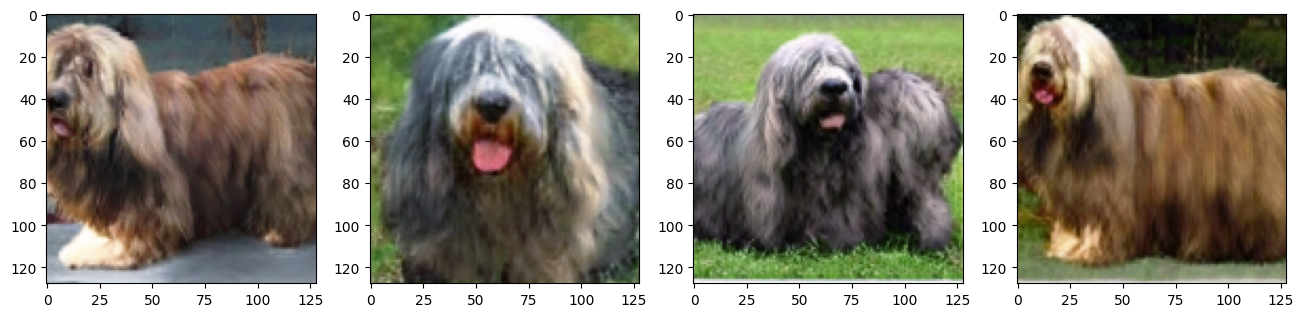

In [2]:
# We want this many images at a time
batch_size = 4

#these deep BigGAN models have as many latent dimensions as pixel width and height
N=128

# Define how much variety we get.
truncation = 0.5

#The model is conditioned by the 1000-value discrete probability distribution of classes.
#First, we initialize the distribution to zeroes
y=np.zeros([batch_size,1000])
# 220 and 229 are both breeds of dog, let's crossbreed
y[:,220]=1
y[:,229]=1

# The latent space vector, randomized
z = truncation*np.random.normal(size=[batch_size, N])  # random vector

#Run the network, feeding the values computed above to the placeholder input tensors
samples_fetched=sess.run(samples,feed_dict={zIn:z,yIn:y,truncationIn:truncation})

#Plot
plt.figure(1,figsize=[batch_size*4,4])
for i in range(batch_size):
    plt.subplot(1,batch_size,1+i)
    plt.imshow(samples_fetched[i]*0.5+0.5)

# Exercise 2: Create small variations

This can be done by keeping the z of some image and then adding some noise to it

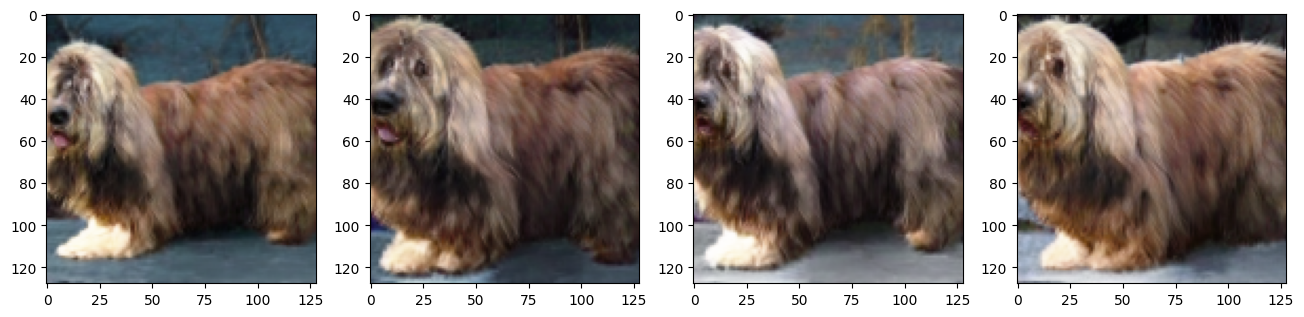

In [3]:
#Let's suppose we want variations of the first image of the batch above
template=z[0,:]

#Now, we create new z by using adding some noise. You can experiment with the noise multiplier.
variations=template+0.2*np.random.normal(size=[batch_size, N])

#Run the network, feeding the values computed above to the placeholder input tensors
samples_fetched=sess.run(samples,feed_dict={zIn:variations,yIn:y,truncationIn:truncation})

#Plot
plt.figure(1,figsize=[batch_size*4,4])
for i in range(batch_size):
    plt.subplot(1,batch_size,1+i)
    plt.imshow(samples_fetched[i]*0.5+0.5)

# Exercise 3: Interpolate between two images

Here, we need to interpolate between two pairs of z and y. The easiest way to do this is linear interpolation, i.e., "cross-fading" between the vectors

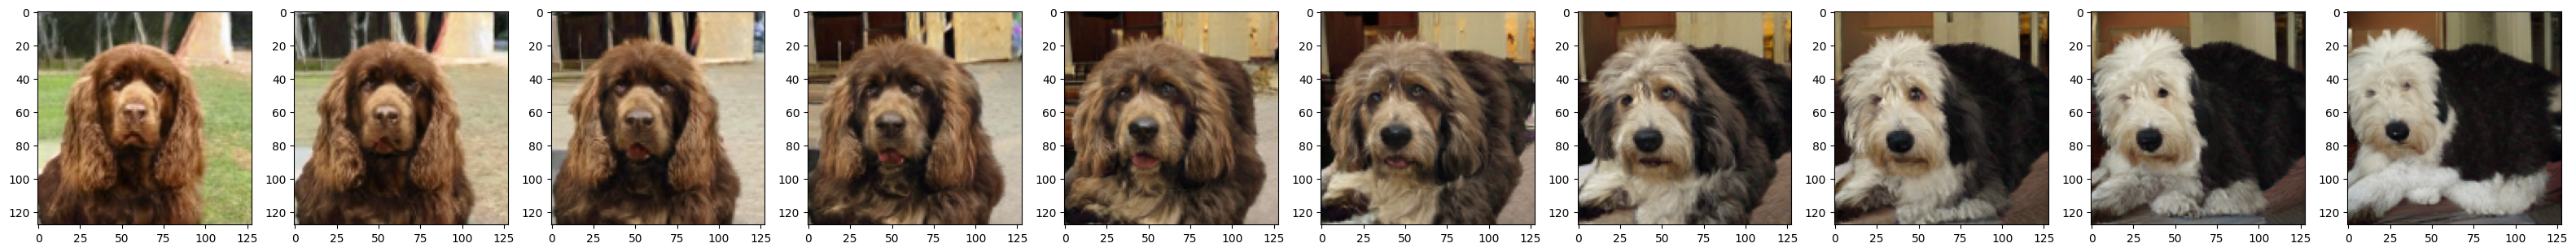

In [4]:
#this many interpolation steps
batch_size=10

#Let's just randomly pick the z vectors
z1=truncation*np.random.normal(size=N)
z2=truncation*np.random.normal(size=N)

#We will use one-hot y vectors
y1=np.zeros(1000)
y1[229]=1
y2=np.zeros(1000)
y2[220]=1

#Reserve space for the interpolated
z=np.zeros([batch_size,128])
y=np.zeros([batch_size,1000])

#Interpolate: The np.linspace() below returns a vector of batch_size elements, values sweeping from 0 to 1
#You could also compute the mixing factor for z1,y1 inside the for loop as (i+1)/batchSize
t=np.linspace(0,1,batch_size)
for i in range(batch_size):
    #we mix together z1 and z2 weighted by t[i] and (1-t[i]), i.e., the mixing weights sum to 1
    z[i]=t[i]*z1+(1.0-t[i])*z2
    y[i]=t[i]*y1+(1.0-t[i])*y2

#Run the network, feeding the values computed above to the placeholder input tensors
samples_fetched=sess.run(samples,feed_dict={zIn:z,yIn:y,truncationIn:truncation})

#Plot
plt.figure(1,figsize=[batch_size*4,4])
for i in range(batch_size):
    plt.subplot(1,batch_size,1+i)
    plt.imshow(samples_fetched[i]*0.5+0.5)


# Rendering the interpolation as video
This extension was kindly contributed by Tuure Saloheimo, spring 2019. This has been tested to work on Colab, but if you run this notebook locally, you have to have ffmpeg installed and set the path correctly (the ```plt.rcParams[]``` below). On Linux, you should be able to find the path using ```which ffmpeg``` from the terminal.

In [5]:
# Import components required for animation
import matplotlib.animation as animation
from IPython.display import HTML

# IMPORTANT: You must set this path correctly, depending on where you have installed ffmpeg.
# This is commented out by default, which works on Colab
# If you don't have ffmpeg, you can download a Windows build for it from https://ffmpeg.zeranoe.com/builds/
#   (check out https://www.ffmpeg.org/download.html for finding builds for other platforms)
#plt.rcParams['animation.ffmpeg_path'] = '/opt/conda/bin/ffmpeg'

# Define starting class
# Complete class list: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
y_1 = np.zeros([1000])
y_1[24] = 1 # owl
# Define final class
y_2 = np.zeros([1000])
y_2[965] = 1 # burrito

# Define the number of samples to collect
# NOTE: setting batch_size too high can result in the program running out of memory,
#       a value of 10 or lower is recommended
batch_count = 15
batch_size = 4
total_samples = batch_count * batch_size

# Randomize the start and end points in the latent space
truncation = 0.7
z_std = 0.7
z_1 = truncation*np.array(np.random.normal(0, z_std, size=[1,N]))
z_2 = truncation*np.array(np.random.normal(0, z_std, size=[1,N]))

# Preparations for storing images
fig = plt.figure()
plt.axis('off')
ims = []

# Collect all samples
for b in range(batch_count):
    print("Collecting samples, batch "+str(b+1)+"/"+str(batch_count), end='\r')
    # Interpolate y and z values for the current batch
    int_y = np.empty([batch_size, 1000])
    int_z = np.empty([batch_size, 128])
    for i in range(batch_size):
        x2 = (i+b*batch_size)/(total_samples-1)
        x1 = 1 - x2
        int_y[i] = x1*y_1 + x2*y_2
        int_z[i] = x1*z_1 + x2*z_2

    # Fetch samples
    samples_fetched = sess.run(samples, feed_dict={zIn:int_z, yIn:int_y, truncationIn:truncation})
    # Store the resulting images
    for i in range(batch_size):
        im = plt.imshow(samples_fetched[i]*0.5+0.5)
        ims.append([im])

print("\nCreating animation")
# Define animation length in seconds
anim_length = 5
# Create animation
ani = animation.ArtistAnimation(fig, ims, interval=anim_length*1000/total_samples, blit=True)
# Close the current plot to prevent last frame from showing as its own plot
plt.close()
# Display the animation
HTML(ani.to_html5_video())


Creating animation
